In [1]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input , Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.mixed_precision import global_policy, set_global_policy, Policy

import cv2 as cv
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

2025-03-20 03:25:32.077049: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 03:25:32.087412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742421332.098977 1385845 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742421332.102423 1385845 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742421332.111788 1385845 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
df = pd.read_csv("dataset/labels.csv")

In [3]:
df["label"].value_counts()

label
0    55
1    55
2    55
3    55
4    55
     ..
v    55
w    55
x    55
y    55
z    55
Name: count, Length: 62, dtype: int64

In [4]:
images_path = 'dataset/img'

In [5]:
images = []
labels = []

In [6]:
for image_file in os.listdir(images_path):
    image_path = os.path.join(images_path, image_file)
    image = cv.imread(image_path).astype('float32')
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image /= 255.0
    label_index = os.path.join("img", image_file)
    label = df[df['image'] == label_index].label.values[0]
    images.append(image)
    labels.append(label)

images = np.array(images)
labels = np.array(labels)


In [7]:
print("Number of images:", len(images))
print("Shape of each image:", images.shape[1:])
print("Unique labels:", np.unique(labels))

Number of images: 3410
Shape of each image: (128, 128)
Unique labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [8]:
encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

In [9]:
images, labels = shuffle(images, labels, random_state=0)

In [10]:
X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,    
    width_shift_range=0.1,  
    height_shift_range=0.2,
    zoom_range=0.2, 
    shear_range=0.2,               
    fill_mode='nearest'
)

In [12]:
augmented_arr_X = []
augmented_arr_Y = []
number_of_augmentation = 5

for i in range(len(X_train)):
    image = X_train[i]
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    
    image_expanded = np.expand_dims(image, axis=0)
    aug_iter = datagen.flow(image_expanded, batch_size=1)
    
    augmented_images = [next(aug_iter)[0] for _ in range(number_of_augmentation)]
    augmented_arr_X.extend(augmented_images)
    augmented_arr_Y.extend([Y_train[i]] * number_of_augmentation)

augmented_arr_X = np.array(augmented_arr_X)
augmented_arr_Y = np.array(augmented_arr_Y)

print("Augmented images shape:", augmented_arr_X.shape)
print("Augmented labels shape:", augmented_arr_Y.shape)

Augmented images shape: (11935, 128, 128, 1)
Augmented labels shape: (11935, 62)


In [13]:
X_train = np.array(augmented_arr_X)
Y_train = np.array(augmented_arr_Y)

In [14]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

In [15]:
model = keras.Sequential([
    Input(shape=(128, 128, 1)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2), 
    
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2), strides=2), 
    
    Conv2D(128, (3, 3), activation='relu', padding ="valid"),
    MaxPooling2D(pool_size=(2, 2), strides=2), 
    
    Flatten(),
    
    Dense(128, activation='relu'), 
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(62, activation='softmax')
])

I0000 00:00:1742421343.298095 1385845 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1959 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 4GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,353,022 (12.79 MB)

 Trainable params: 3,353,022 (12.79 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
policy = Policy('mixed_float16')
set_global_policy(policy)

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [18]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
history = model.fit(
    X_train, Y_train,
    epochs=25, 
    batch_size=16,  
    validation_data=(X_val, Y_val),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/25


I0000 00:00:1742421345.440142 1386618 service.cc:152] XLA service 0x7255bc020050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742421345.440160 1386618 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 4GB Laptop GPU, Compute Capability 8.6
2025-03-20 03:25:45.464431: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742421345.624886 1386618 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/746 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.0165 - loss: 4.1498

I0000 00:00:1742421350.309079 1386618 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


746/746 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0203 - loss: 4.1260

2025-03-20 03:26:11.028233: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118', 104 bytes spill stores, 104 bytes spill loads

2025-03-20 03:26:12.672773: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_118', 108 bytes spill stores, 108 bytes spill loads



746/746 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.0203 - loss: 4.1259 - val_accuracy: 0.0333 - val_loss: 3.8970 - learning_rate: 1.0000e-04
Epoch 2/25
746/746 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.0596 - loss: 3.8566 - val_accuracy: 0.2485 - val_loss: 3.0707 - learning_rate: 1.0000e-04
Epoch 3/25
746/746 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.1616 - loss: 3.2313 - val_accuracy: 0.3366 - val_loss: 2.4340 - learning_rate: 1.0000e-04
Epoch 4/25
746/746 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.2656 - loss: 2.7078 - val_accuracy: 0.4951 - val_loss: 1.8727 - learning_rate: 1.0000e-04
Epoch 5/25
746/746 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.3578 - loss: 2.2729 - val_accuracy: 0.5577 - val_loss: 1.5975 - learning_rate: 1.0000e-04
Epoch 6/25
746/746 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.4465 - loss: 1.9384 - val_accuracy: 0.6067 - val_loss: 1.3714 - learning_rate: 1.0000e-04
Epoch 7/25
746/746 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accurac

In [20]:
model.save("model.keras")

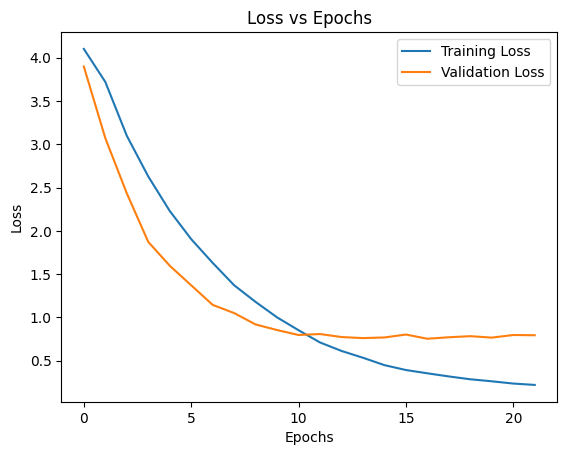

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

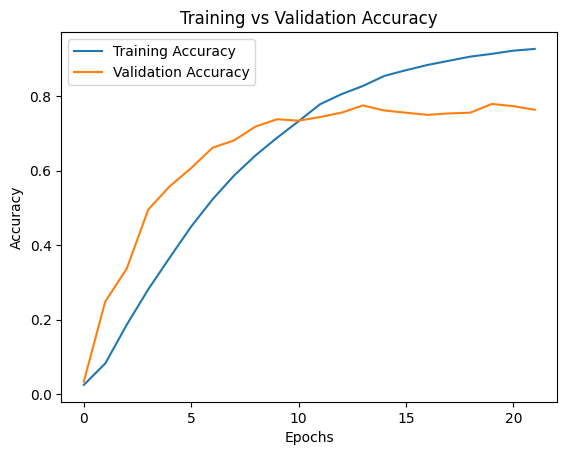

In [23]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()